# Time series Analysis on xG prediction

1. Load the data
2. Check statonary
3. Change the format to make it stationary
4. Model selectoin (AR, MA, ARMA, ARIMA)
5. Add time lag feature into machine learning model

## Load data

In [68]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import datetime 
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from xg_model_pipeline import *

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline


In [2]:
def parse_date(x):
    return datetime.datetime.strptime(x.split(' ')[0], '%Y-%m-%d')

df = pd.read_csv('/Users/marceloyou/Desktop/Xg-Prediction/data/xG/2015-2022xgdata.csv', parse_dates=[2], date_parser=parse_date)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Season                      2806 non-null   object        
 1   id                          2806 non-null   int64         
 2   datetime                    2806 non-null   datetime64[ns]
 3   team                        2806 non-null   object        
 4   opponent                    2806 non-null   object        
 5   home                        2806 non-null   int64         
 6   oppo_home                   2806 non-null   int64         
 7   team_recent_goals           2806 non-null   float64       
 8   team_recent_conced          2806 non-null   float64       
 9   team_recent_xG              2806 non-null   float64       
 10  oppo_recent_goals           2806 non-null   float64       
 11  oppo_recent_conced          2806 non-null   float64     

In [4]:
# select team
def select_team_data(data, team, season = None):
    if season:
        return data.loc[(data['Season'] == f'{season}-{season+1}') &((data['opponent'] == team) | (data['team'] == team))]
    else:
        return data.loc[(data['opponent'] == team) | (data['team'] == team)]

def transform_to_xG(data, team):
    df = select_team_data(data, team)
    df.reset_index(inplace = True)
    for i in range(df.shape[0]):
        if df.loc[i, 'team'] == team:
             pass
        else:
            df.loc[i, ['team_recent_goals', 'team_recent_xG']], df.loc[i, 'oppo_recent_conced'] = df.loc[i, ['oppo_recent_goals', 'oppo_recent_xG']].values,df.loc[i, 'team_recent_conced']
            df.loc[i, ['home', 'team_rank']],df.loc[i, ['oppo_home', 'oppo_rank']] = df.loc[i, ['oppo_home', 'oppo_rank']].values, df.loc[i, ['home', 'team_rank']].values
            df.loc[i, 'team'], df.loc[i, 'opponent'] = df.loc[i, 'opponent'], df.loc[i, 'team']
            df.loc[i, ['team_cumsum_goals', 'team_cumsum_shots','team_cumsum_xg']], df.loc[i, 'oppo_cumsum_conced'] = df.loc[i, ['oppo_cumsum_goals', 'oppo_cumsum_shots','oppo_cumsum_xg']].values, df.loc[i, 'team_cumsum_conced']
            df.loc[i, ['team_cumsum_goal_pergame', 'team_cumsum_shot_pergame','team_cumsum_xg_pergame']], df.loc[i, 'oppo_cumsum_conced_pergame'] = df.loc[i, ['oppo_cumsum_goal_pergame', 'oppo_cumsum_shot_pergame','oppo_cumsum_xg_pergame']].values, df.loc[i, 'team_cumsum_conced_pergame']
            df.loc[i, 'team_history_goals'] = df.loc[i, 'oppo_history_goals']
            df.loc[i, 'team_xG'], df.loc[i, 'oppo_xG'] = df.loc[i, 'oppo_xG'], df.loc[i, 'team_xG']
    df = df[['Season', 'datetime','id', 'team', 'opponent', 'home','team_recent_goals', 'team_recent_xG','oppo_recent_conced', \
            'team_stage', 'team_rank', 'oppo_rank', 'month', 'weekday','game_period', \
            'team_cumsum_goals', 'team_cumsum_shots','team_cumsum_xg', 'team_cumsum_goal_pergame', 'team_cumsum_shot_pergame','team_cumsum_xg_pergame', \
                'oppo_cumsum_conced', 'oppo_cumsum_conced_pergame', 'team_history_goals', 'team_xG']]
    return df

arsenal = transform_to_xG(df, 'Arsenal')

Text(0.5, 1.0, 'Date Against xG Arsenal')

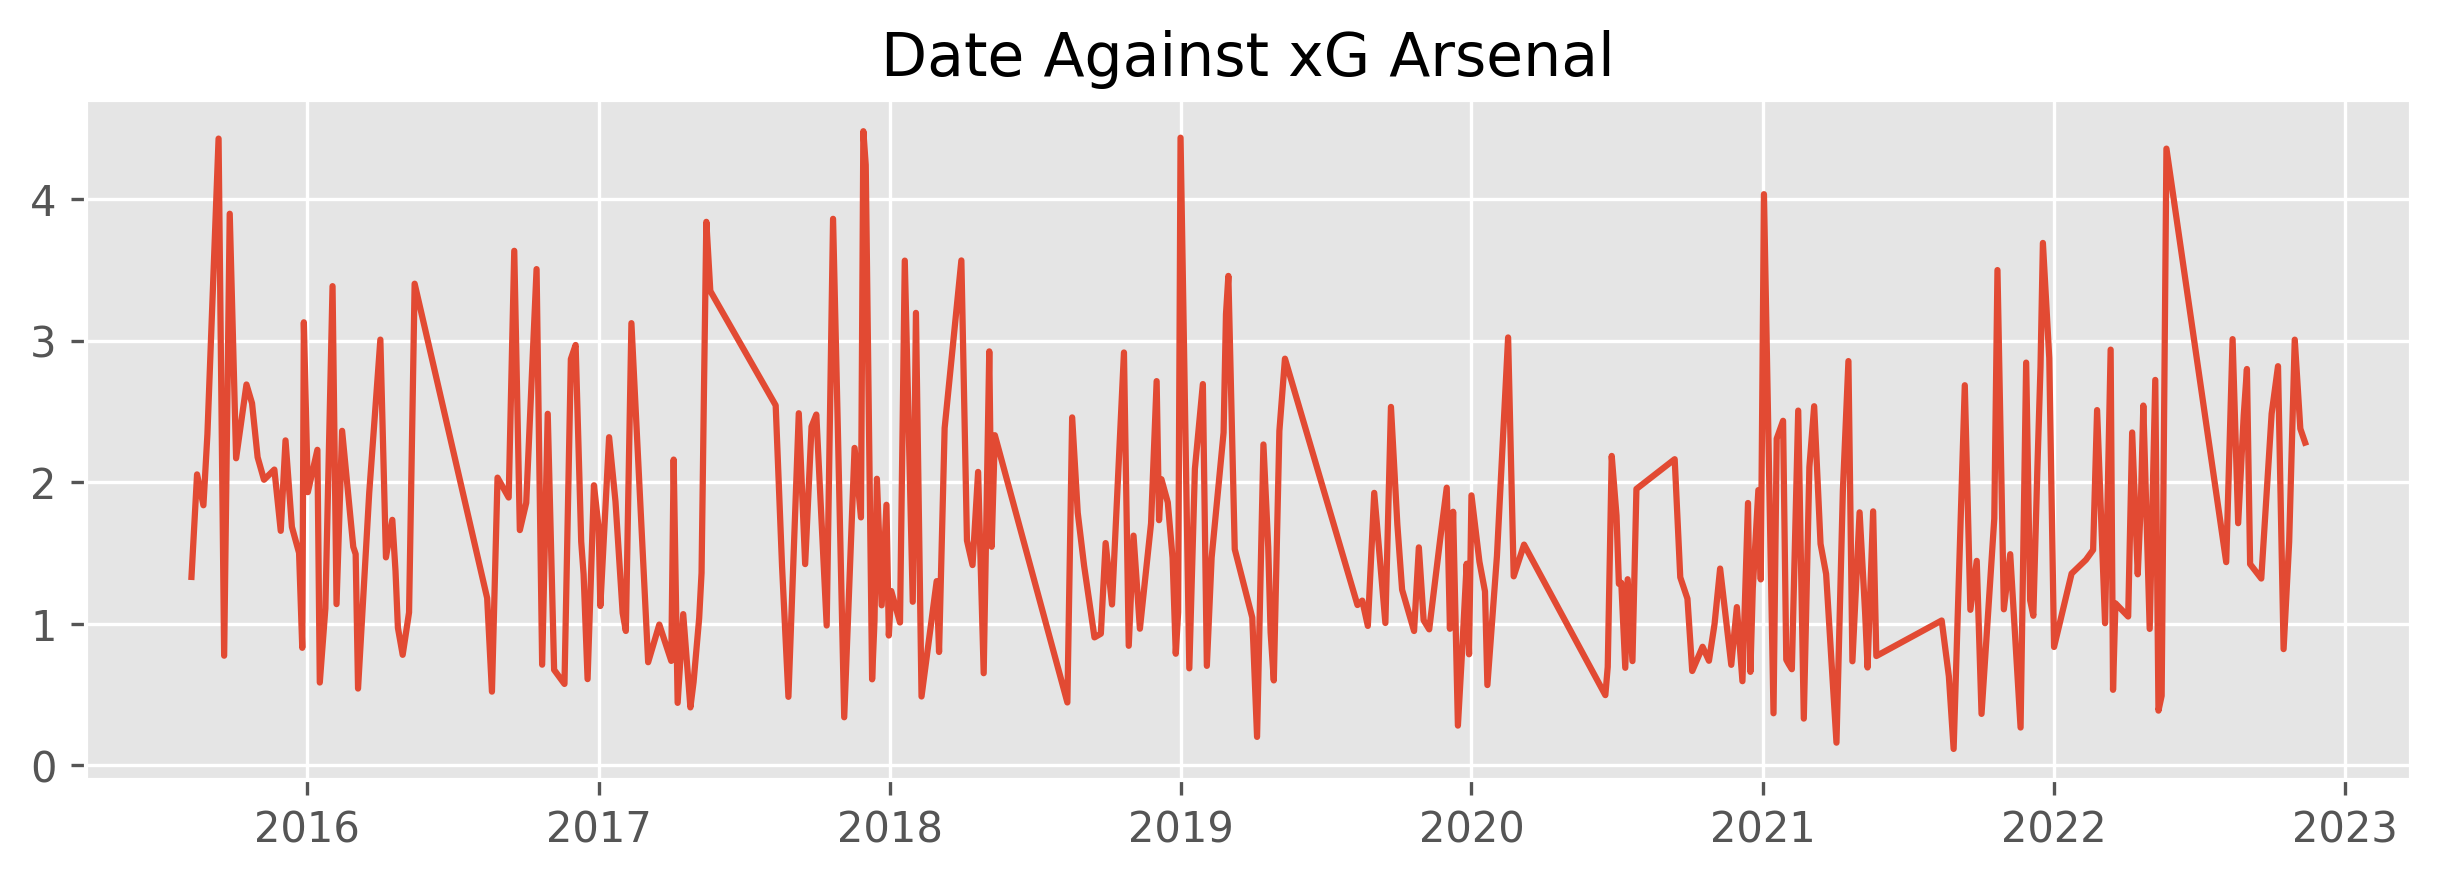

In [37]:
time_arsenal = arsenal[['datetime','team_xG']]


fig = plt.figure(figsize = (10, 3), dpi = 300)

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,13)))
plt.plot(time_arsenal['datetime'], time_arsenal['team_xG'])
# plt.gcf().autofmt_xdate()
plt.title('Date Against xG Arsenal')


## Check stationary

Things to consider:
1. mean of xG
2. varinace of xG
3. Autocorrelation

Methods to check:
* calculate mean and vainace of the interval(rolling mean and rolling variance)
* Dickey-Fuller Test


In [34]:
# mean and variance
def draw_trend(timeseries, size):
    fig, ax = plt.subplots(1,1, figsize = (8,3), dpi = 300)
    fig.set_dpi(300)
    # rolling mean
    rol_mean = timeseries.rolling(window=size).mean()
    # rolling variance
    rol_std = timeseries.rolling(window=size).std()
 
    timeseries.plot(color='blue', ax = ax)
    rol_mean.plot(color='red', ax = ax)
    rol_std.plot(color='black',ax = ax)
    plt.legend(['Original','Rolling Mean','Rolling standard deviation'], loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
 
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()


def teststationarity(ts,max_lag = None):
    dftest = sm.tsa.stattools.adfuller(ts,maxlag= max_lag)
    # output the hypothesis output
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput



In [50]:
# see the mena and varianced
time_arsenal.set_index('datetime', inplace=True)


KeyError: "None of ['datetime'] are in the columns"

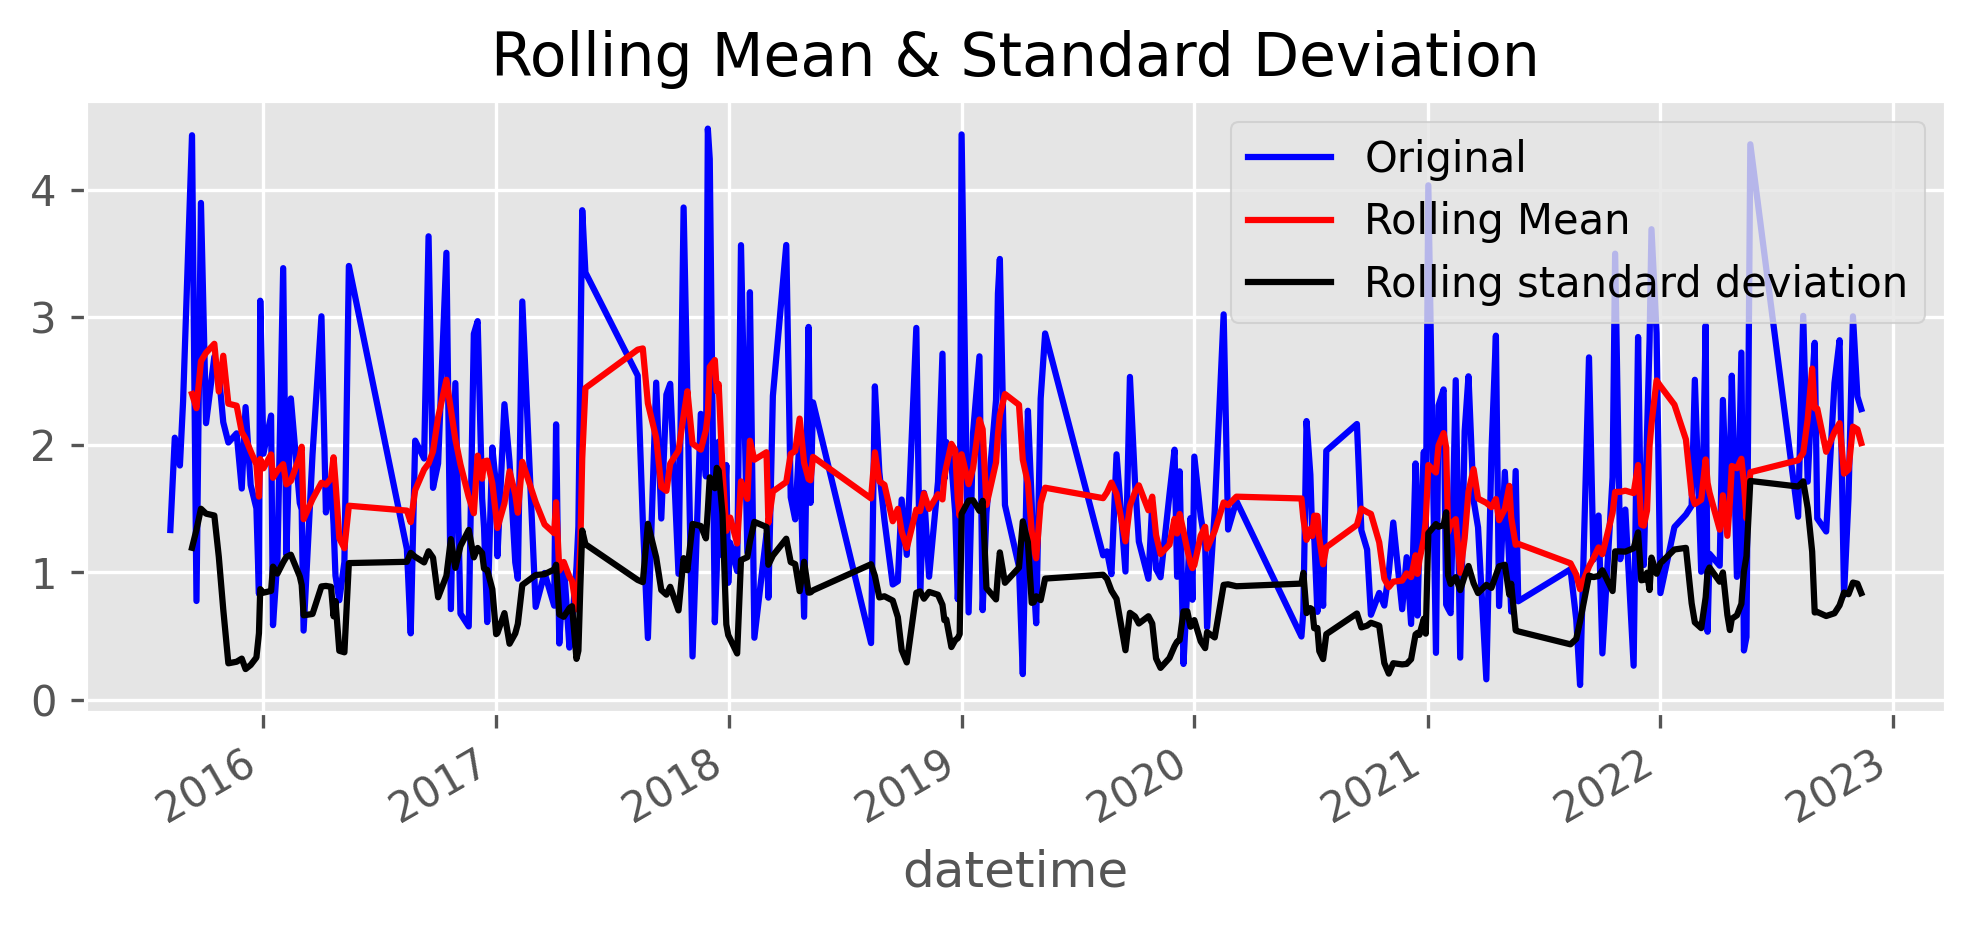

In [59]:
draw_trend(time_arsenal, 5)

In [69]:
teststationarity(time_arsenal)

Test Statistic                -6.207031e+00
p-value                        5.625179e-08
#Lags Used                     4.000000e+00
Number of Observations Used    2.750000e+02
Critical Value (1%)           -3.454355e+00
Critical Value (5%)           -2.872108e+00
Critical Value (10%)          -2.572401e+00
dtype: float64

## Model selection

1. plot acf and pacf to make sure order of the model
2. Fit the arma model
3. Prediction and evaluation(MAE, MSE)

In [47]:
def draw_acf_pacf(ts,lags = None):
    f = plt.figure(facecolor='white', figsize=(8,6))
    ax1 = f.add_subplot(211)
    sm.graphics.tsa.plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    sm.graphics.tsa.plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
#draw_acf_pacf(time_arsenal)


## Model 

From the plot we can tell p = 5, q = 5, a model ARMA(5,5) will be fitted

In [137]:
train = time_arsenal.iloc[:-5]
test = time_arsenal.iloc[-5:]

arma_model = ARIMA(train.team_xG.values, order = (1,0,1))
res = arma_model.fit()

In [103]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -370.775
Date:                Wed, 07 Dec 2022   AIC                            749.551
Time:                        11:48:47   BIC                            764.018
Sample:                             0   HQIC                           755.357
                                - 275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6732      0.067     24.951      0.000       1.542       1.805
ar.L1         -0.9567      0.066    -14.547      0.000      -1.086      -0.828
ma.L1          0.9764      0.051     19.092      0.000       0.876       1.077
sigma2         0.8679      0.085     10.267      0.000       0.702       1.034
===================================================================================
Ljung-Box (Q):                       45.71   Jarque-Bera (JB):                26.68
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.76
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
def evaluation(test, model):
    predict_xg = np.array(model.forecast(5))
    mae, mse = mean_absolute_error(test.team_xG.values, predict_xg), mean_squared_error(test.team_xG.values, predict_xg)
    print(f'MAE: {mae:.3f} \n MSE: {mse: .3f}')
    test['predict'] = predict_xg

    fig, ax = plt.subplots(1,2, figsize = (8,3))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    fig.set_dpi(300)
    test.reset_index().plot(x = 'datetime', y = 'team_xG', ax = ax[0])
    test.reset_index().plot(x = 'datetime', y = 'predict',ax = ax[0])
    ax[0].legend(['Original', 'Predict'], loc = 'best')
    ax[0].set_title('Predict VS Original')

    test['residual'] = test['team_xG'] - test['predict']
    test.reset_index().plot(x = 'datetime', y = 'residual', ax = ax[1])
    ax[1].set_title("Residual Plot")
    ax[1].axhline(0, color ='r', linestyle = '--', alpha = 0.2)
    

MAE: 0.730 
 MSE:  0.690


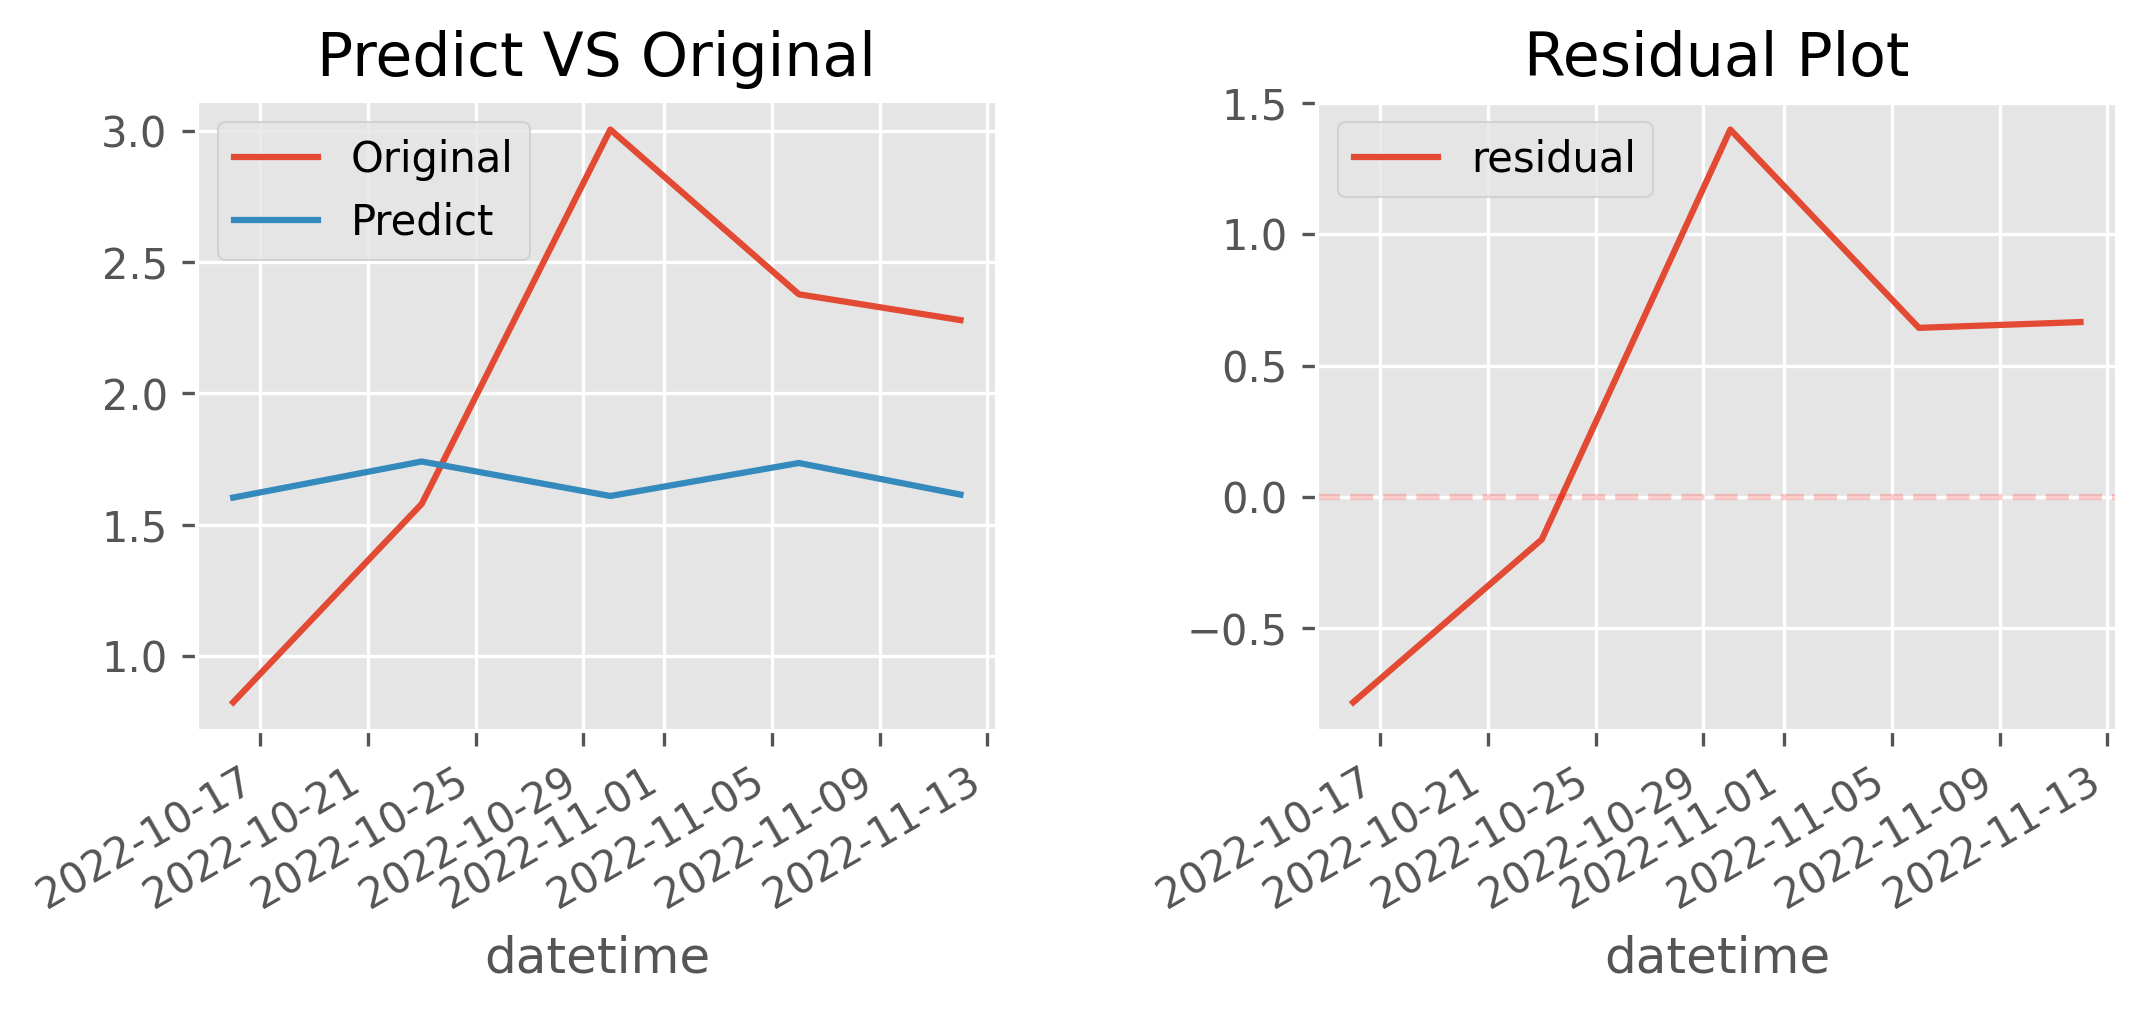

In [160]:
evaluation(test, res)

## Add features into Arsenal data

In [5]:
arsenal['lag1'] = arsenal['team_xG'].shift(1)

In [6]:
arsenal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Season                      280 non-null    object        
 1   datetime                    280 non-null    datetime64[ns]
 2   id                          280 non-null    int64         
 3   team                        280 non-null    object        
 4   opponent                    280 non-null    object        
 5   home                        280 non-null    int64         
 6   team_recent_goals           280 non-null    float64       
 7   team_recent_xG              280 non-null    float64       
 8   oppo_recent_conced          280 non-null    float64       
 9   team_stage                  280 non-null    int64         
 10  team_rank                   280 non-null    int64         
 11  oppo_rank                   280 non-null    int64         

In [8]:
from xg_model_pipeline import *

arsenal_datetime = arsenal['datetime']

In [9]:
arsenal.drop(columns = ['datetime', 'id', 'team'], inplace = True)

arsenal = encode_coulumns(arsenal, ['Season', 'opponent', 'game_period'])

#arsenal = change_col_category(arsenal, ['Season', 'opponent', 'home', 'team_stage', 'game_period', 'weekday'])

In [10]:
arsenal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Season                      280 non-null    category
 1   opponent                    280 non-null    category
 2   home                        280 non-null    category
 3   team_recent_goals           280 non-null    float64 
 4   team_recent_xG              280 non-null    float64 
 5   oppo_recent_conced          280 non-null    float64 
 6   team_stage                  280 non-null    category
 7   team_rank                   280 non-null    int64   
 8   oppo_rank                   280 non-null    int64   
 9   month                       280 non-null    int64   
 10  weekday                     280 non-null    category
 11  game_period                 280 non-null    category
 12  team_cumsum_goals           280 non-null    float64 
 13  team_cumsum_shots   

In [15]:
import xgboost as xbg 
from sklearn.ensemble import RandomForestRegressor


train = arsenal.iloc[:-5]
test = arsenal.iloc[-5:]
train.dropna(inplace = True)

In [20]:
xgboost = xbg.XGBRegressor(
    
)

In [21]:
xgboost.fit(train.drop(columns = 'team_xG'), train['team_xG'])

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Season, opponent, home, team_stage, weekday, game_period

In [46]:
predict_y = xgboost.predict(test.drop(columns = ['team_xG']))

In [47]:
test_y = test['team_xG']
print(f'The MAE: {mean_absolute_error(test_y, predict_y)} \n The MSE: {mean_squared_error(test_y, predict_y)}')

The MAE: 0.9515997955184938 
 The MSE: 1.312107696394245


## Check Rfr regressor and timer series model

In [24]:
rfr = RandomForestRegressor(bootstrap = True, oob_score = True)

rfr.fit(train.drop(columns = 'team_xG'), train['team_xG'])

RandomForestRegressor(oob_score=True)

In [25]:
predict_y = rfr.predict(test.drop(columns = ['team_xG']))
test_y = test['team_xG']
print(f'The MAE: {mean_absolute_error(test_y, predict_y)} \n The MSE: {mean_squared_error(test_y, predict_y)}')

The MAE: 0.6191486239999999 
 The MSE: 0.4938677576489104


In [30]:
train_predict = rfr.oob_prediction_

In [42]:
residual = train['team_xG'] - train_predict

residual_df = pd.DataFrame({'datetime': arsenal_datetime[1:-5], 'residual': residual})

residual_df.set_index('datetime', inplace = True)


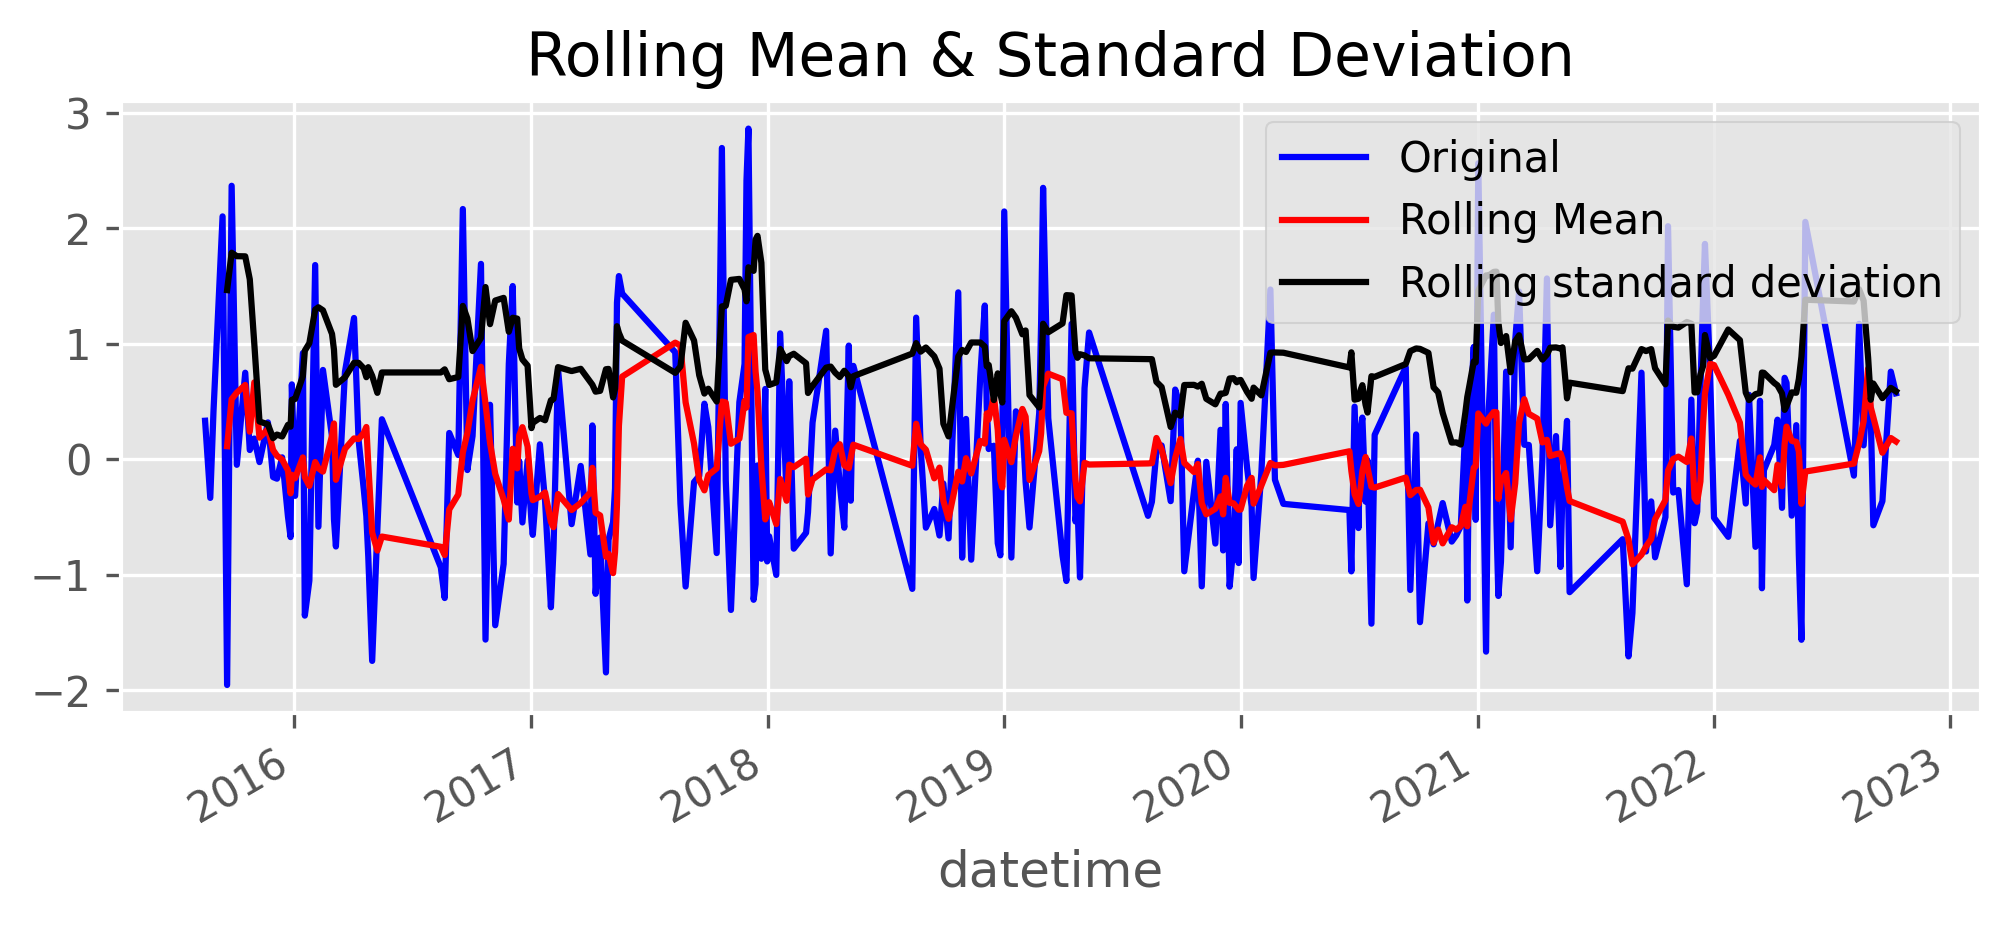

In [43]:
draw_trend(residual_df, 5)

In [44]:
teststationarity(residual_df)

Test Statistic                -1.699026e+01
p-value                        8.879745e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.730000e+02
Critical Value (1%)           -3.454533e+00
Critical Value (5%)           -2.872186e+00
Critical Value (10%)          -2.572443e+00
dtype: float64

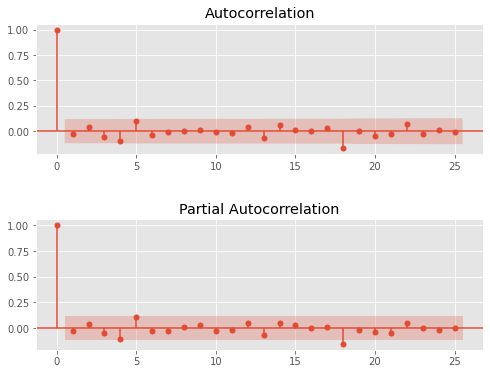

In [48]:
draw_acf_pacf(residual_df)

In [53]:
arma_model = ARIMA(residual_df['residual'].values, order = (1,0,1))
res = arma_model.fit()

In [54]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  274
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -360.082
Date:                Fri, 16 Dec 2022   AIC                            728.164
Time:                        14:20:23   BIC                            742.617
Sample:                             0   HQIC                           733.965
                                - 274                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0403      0.060     -0.672      0.501      -0.158       0.077
ar.L1         -0.3862      1.227     -0.315      0.753      -2.790       2.018
ma.L1          0.3467      1.238      0.280      0.779      -2.080       2.773
sigma2         0.8110      0.071     11.392      0.000       0.671       0.950
===================================================================================
Ljung-Box (Q):                       36.11   Jarque-Bera (JB):                25.95
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.72
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
train.columns

Index(['Season', 'opponent', 'home', 'team_recent_goals', 'team_recent_xG',
       'oppo_recent_conced', 'team_stage', 'team_rank', 'oppo_rank', 'month',
       'weekday', 'game_period', 'team_cumsum_goals', 'team_cumsum_shots',
       'team_cumsum_xg', 'team_cumsum_goal_pergame',
       'team_cumsum_shot_pergame', 'team_cumsum_xg_pergame',
       'oppo_cumsum_conced', 'oppo_cumsum_conced_pergame',
       'team_history_goals', 'team_xG', 'lag1'],
      dtype='object')